<a href="https://colab.research.google.com/github/nisharamanna555/ResponsibleDataScience/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install fairlearn

In [ ]:
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

## NOTE: If the top two cells give you errors:
### 1. Open `Runtime` in the top bar
### 2. Press `Restart session`
### 3. Try running the cells again
#### (This is not the same thing as reloading the page!)

(if this still doesn't work, post a **private** message on Piazza or come to hours)

# Load and preprocess the data

In [ ]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [ ]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [ ]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [ ]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,3,Missing,49,6,27,...,NaN,NaN,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,'Over 60 years',Other,Referral,5,Missing,57,0,21,...,NaN,NaN,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,'30-60 years','Discharged to Home',Other,4,Other,37,2,9,...,NaN,NaN,No,No,No,False,False,False,False,False
51185,Caucasian,Male,'30-60 years',Other,Other,9,InternalMedicine,61,6,27,...,NaN,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,'30-60 years','Discharged to Home',Referral,7,Other,23,0,13,...,NaN,NaN,No,No,Yes,True,False,True,True,False


In [ ]:
# check how many 'Unknown/Invalid' values there are for gender
(x_raw.gender == 'Unknown/Invalid').sum()

0

In [ ]:
# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [ ]:
x_raw.dtypes

race                          object
gender                        object
age                           object
discharge_disposition_id      object
admission_source_id           object
time_in_hospital               int64
medical_specialty             object
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
primary_diagnosis             object
number_diagnoses               int64
max_glu_serum                 object
A1Cresult                     object
insulin                       object
change                        object
diabetesMed                   object
medicare                    category
medicaid                    category
had_emergency               category
had_inpatient_days          category
had_outpatient_days         category
dtype: object

In [ ]:
unique_feature_values = x_raw.apply(lambda col: col.unique())
unique_feature_values

race                        [Caucasian, AfricanAmerican, Unknown, Other, A...
gender                                                         [Male, Female]
age                         ['Over 60 years', '30-60 years', '30 years or ...
discharge_disposition_id                        ['Discharged to Home', Other]
admission_source_id                              [Emergency, Referral, Other]
time_in_hospital              [3, 5, 4, 9, 7, 8, 11, 2, 1, 6, 12, 13, 14, 10]
medical_specialty           [Missing, Other, InternalMedicine, Emergency/T...
num_lab_procedures          [49, 57, 37, 61, 23, 65, 47, 35, 51, 22, 46, 4...
num_procedures                                          [6, 0, 2, 1, 3, 4, 5]
num_medications             [27, 21, 9, 13, 40, 17, 34, 10, 19, 11, 6, 14,...
primary_diagnosis           [Other, Diabetes, 'Respiratory Issues', 'Muscu...
number_diagnoses                  [9, 5, 7, 4, 6, 8, 3, 2, 1, 16, 15, 13, 11]
max_glu_serum                                         [nan, Norm

In [ ]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'insulin']


In [ ]:
#@markdown
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True)

In [ ]:
#@markdown
%%capture
x_raw.apply(lambda col: col.unique())


In [ ]:
x_raw.dtypes

race                                             category
age                                              category
admission_source_id                              category
time_in_hospital                                    int64
medical_specialty                                category
num_lab_procedures                                  int64
num_procedures                                      int64
num_medications                                     int64
primary_diagnosis                                category
number_diagnoses                                    int64
max_glu_serum                                      object
A1Cresult                                          object
insulin                                          category
gender_Male                                         int64
discharge_disposition_id_'Discharged to Home'       int64
change_Ch                                           int64
diabetesMed_Yes                                     int64
medicare_False

In [ ]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'float64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'float64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Male,discharge_disposition_id_'Discharged to Home',change_Ch,diabetesMed_Yes,medicare_False,...,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
86278,5,57,0,21,9,0,0,1,1,0,...,False,False,False,False,False,False,False,True,False,False
30000,4,37,2,9,5,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,False
51185,9,61,6,27,9,1,0,1,1,1,...,False,False,False,False,True,False,False,True,False,False
53902,7,23,0,13,7,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
#@markdown ## TODO: Split train, test, validation data 70 train/20 test/10 val

# split into 70% train, 30% temp set
  # X = x_numeric
  # y = y_raw
X_train, X_temp, y_train, y_temp = train_test_split(x_numeric, y_raw, test_size=0.3, random_state=1)
# split temp into 20% test, 10% val
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=1)

In [ ]:
#@markdown ## TODO: Initialize Fairlearn Metric Dictrs and sensitive features

sensitive_features = X_test['gender_Male'].replace({0:'female', 1:'male'})

# evaluation metrics
eval_metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate}

# fairness metrics
fair_metrics = {'FNRdiff': false_negative_rate_difference,
                    'FPRdiff': false_positive_rate_difference,
                    'DPR': demographic_parity_ratio,
                    'EOR': equalized_odds_ratio,
                    'SRD': selection_rate_difference}
params = {'FNRdiff': {"sensitive_features": sensitive_features},
          'FPRdiff': {"sensitive_features": sensitive_features},
          'DPR': {"sensitive_features": sensitive_features},
          'EOR': {"sensitive_features": sensitive_features},
          'SRD': {"sensitive_features": sensitive_features}}

# Problem 2, Part (a)
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# predict on test
y_pred = clf.predict(X_test)

### Report metrics

In [ ]:
#@markdown ### Calculate metrics with Fairlearn MetricFrame

grouped_on_sex_eval = MetricFrame(metrics=eval_metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_features)

grouped_on_sex_fair = MetricFrame(metrics=fair_metrics,
                                  y_true=y_test,
                                  y_pred=y_pred,
                                  sensitive_features=sensitive_features,
                                  sample_params=params)

In [ ]:
#@markdown Print Results

print("EVALUATION METRICS:")
print(grouped_on_sex_eval.overall)

print("\n\nFAIRNESS METRICS:")
print(grouped_on_sex_fair.overall)

EVALUATION METRICS:
accuracy     0.592338
precision    0.567500
recall       0.484009
FNR          0.515991
FPR          0.315118
dtype: float64


FAIRNESS METRICS:
FNRdiff    0.177410
FPRdiff    0.093056
DPR        0.698900
EOR        0.685556
SRD        0.137934
dtype: float64


In [ ]:
#markdown # Problem 2, Part (b)
#markdown ### **Hyperparameter tuning of baseline RF model**
from sklearn.model_selection import GridSearchCV

def tune_random_forest(x_train, y_train, x_val, y_val, max_depth, n_estimators, verbose=False, weights=None):
    '''Tunes logistic regression models over the hyperparameters max depth and n_estimators
       to maximize the AUC'''
    # combine training and validation sets for input b/c I'm using GridSearchCV
    X = pd.concat([x_train, x_val], ignore_index=True)
    y = pd.concat([y_train, y_val], ignore_index=True)
    param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
    clf = RandomForestClassifier(class_weight=weights, random_state=42)
    tuned_clf = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc', verbose=int(verbose))
    tuned_clf.fit(X, y)

    # return best model and its associated parameters created GridSearchCV
    return tuned_clf.best_estimator_, tuned_clf.best_params_

In [ ]:
#markdown Tuning loop across different seeds

untuned_results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []}
tuned_results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []}
best_params_arr = []

for i in range(10):
  X_train, X_temp, y_train, y_temp = train_test_split(x_numeric, y_raw, test_size=0.3, random_state=i)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=i)
  sensitive_features = X_test['gender_Male'].replace({0:'female', 1:'male'})
  # untuned model
  untuned_clf = RandomForestClassifier(random_state=i)
  untuned_clf.fit(X_train, y_train)
  untuned_y_pred = untuned_clf.predict(X_test)
  untuned_eval = MetricFrame(metrics=eval_metrics,
                             y_true=y_test,
                             y_pred=untuned_y_pred,
                             sensitive_features=sensitive_features)
  untuned_fair = MetricFrame(metrics=fair_metrics,
                             y_true=y_test,
                             y_pred=untuned_y_pred,
                             sensitive_features=sensitive_features,
                             sample_params=params)
  for metric in untuned_results.keys():
    if metric in untuned_eval.overall:
      untuned_results[metric].append(untuned_eval.overall[metric])
    else:
      untuned_results[metric].append(untuned_fair.overall[metric])
  # tuned model
  tuned_clf, best_params = tune_random_forest(X_train, y_train, X_val, y_val, [5, 10, 15, 20], [50, 100, 150, 200])
  best_params_arr.append(best_params)
  tuned_y_pred = tuned_clf.predict(X_test)
  tuned_eval = MetricFrame(metrics=eval_metrics,
                             y_true=y_test,
                             y_pred=tuned_y_pred,
                             sensitive_features=sensitive_features)
  tuned_fair = MetricFrame(metrics=fair_metrics,
                             y_true=y_test,
                             y_pred=tuned_y_pred,
                             sensitive_features=sensitive_features,
                             sample_params=params)
  for metric in tuned_results.keys():
    if metric in tuned_eval.overall:
      tuned_results[metric].append(tuned_eval.overall[metric])
    else:
      tuned_results[metric].append(tuned_fair.overall[metric])

In [ ]:
for i in best_params_arr:
  print(i)

{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 5, 'n_estimators': 200}
{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 5, 'n_estimators': 200}
{'max_depth': 5, 'n_estimators': 200}
{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 10, 'n_estimators': 200}
{'max_depth': 5, 'n_estimators': 200}


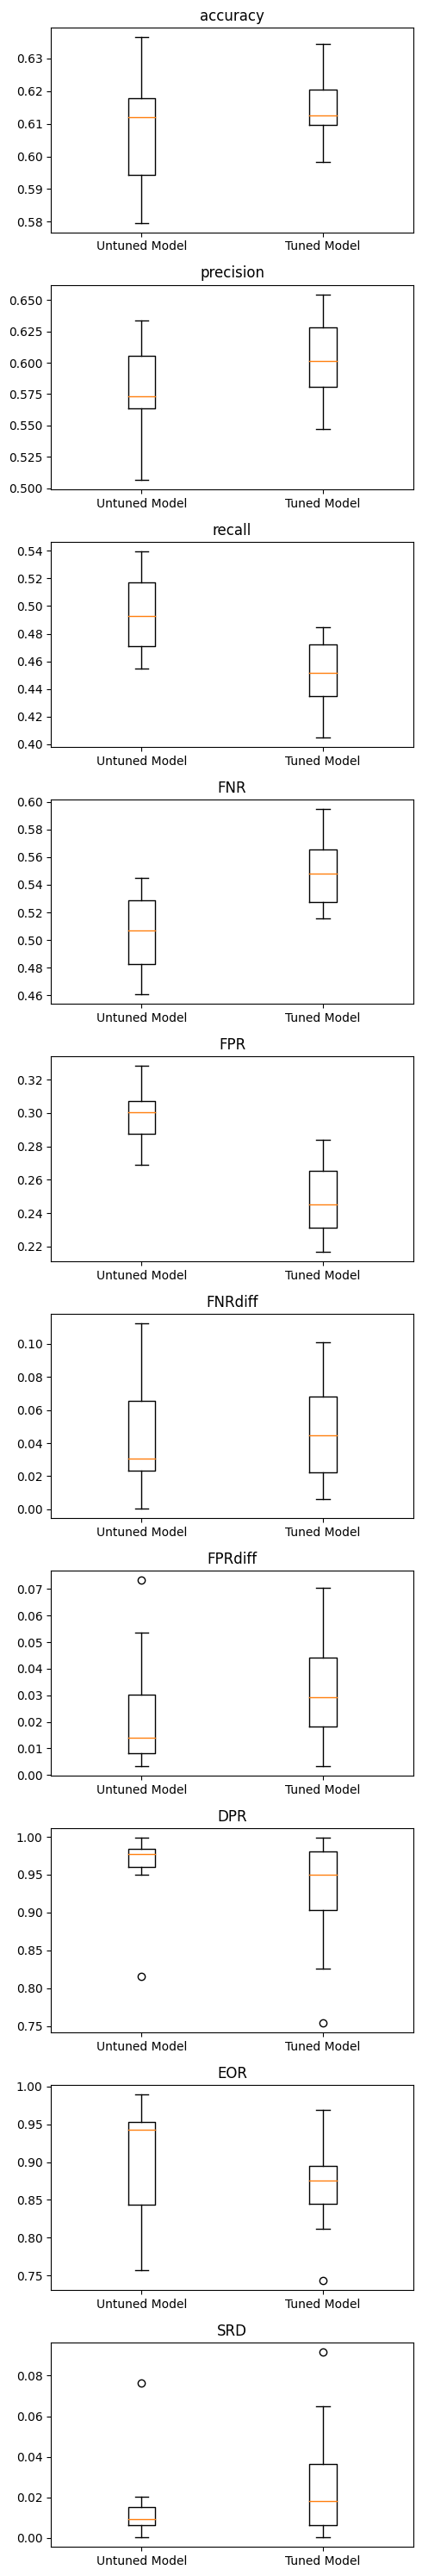

In [ ]:
#markdown ### Boxplot tuned/untuned comparison for each metric

fig, axs = plt.subplots(len(untuned_results), 1, figsize=(5, 3 * len(untuned_results)))

for i in range(len(untuned_results)):
  # creating plot
  bp = axs[i].boxplot(list(untuned_results.values())[i], positions=[1], labels=['Untuned Model'])
  bp2 = axs[i].boxplot(list(tuned_results.values())[i], positions=[2], labels=['Tuned Model'])
  axs[i].set_title(list(untuned_results)[i])
# show plot
plt.tight_layout()
plt.show()

# Problem 2, Part (c)
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [ ]:
from re import A
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []}

alphas = [0.0, 0.3, 0.7, 1.0]

for i in range(10):
  X_train, X_temp, y_train, y_temp = train_test_split(x_numeric, y_raw, test_size=0.3, random_state=i)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=i)
  sensitive_features_train = X_train['gender_Male'].replace({0:'female', 1:'male'})
  sensitive_features_test = X_test['gender_Male'].replace({0:'female', 1:'male'})
  curr_results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []
  }
  for alpha in alphas:
    clf = AdversarialFairnessClassifier(alpha=alpha,
                                        backend='tensorflow',
                                        predictor_model=[128,64,32,16,8],
                                        adversary_model=[32,16,8],
                                        learning_rate=0.001, epochs=3,
                                        batch_size=16,
                                        constraints='demographic_parity',
                                        random_state=i,
                                        shuffle=True)
    clf.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    y_pred = clf.predict(X_test)
    eval = MetricFrame(metrics=eval_metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=sensitive_features_test)
    fair = MetricFrame(metrics=fair_metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=sensitive_features_test,
                              sample_params=params)
    for metric in curr_results.keys():
      if metric in eval.overall:
        curr_results[metric].append(eval.overall[metric])
      else:
        curr_results[metric].append(fair.overall[metric])
  for metric in curr_results.keys():
    results[metric].append(curr_results[metric])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each

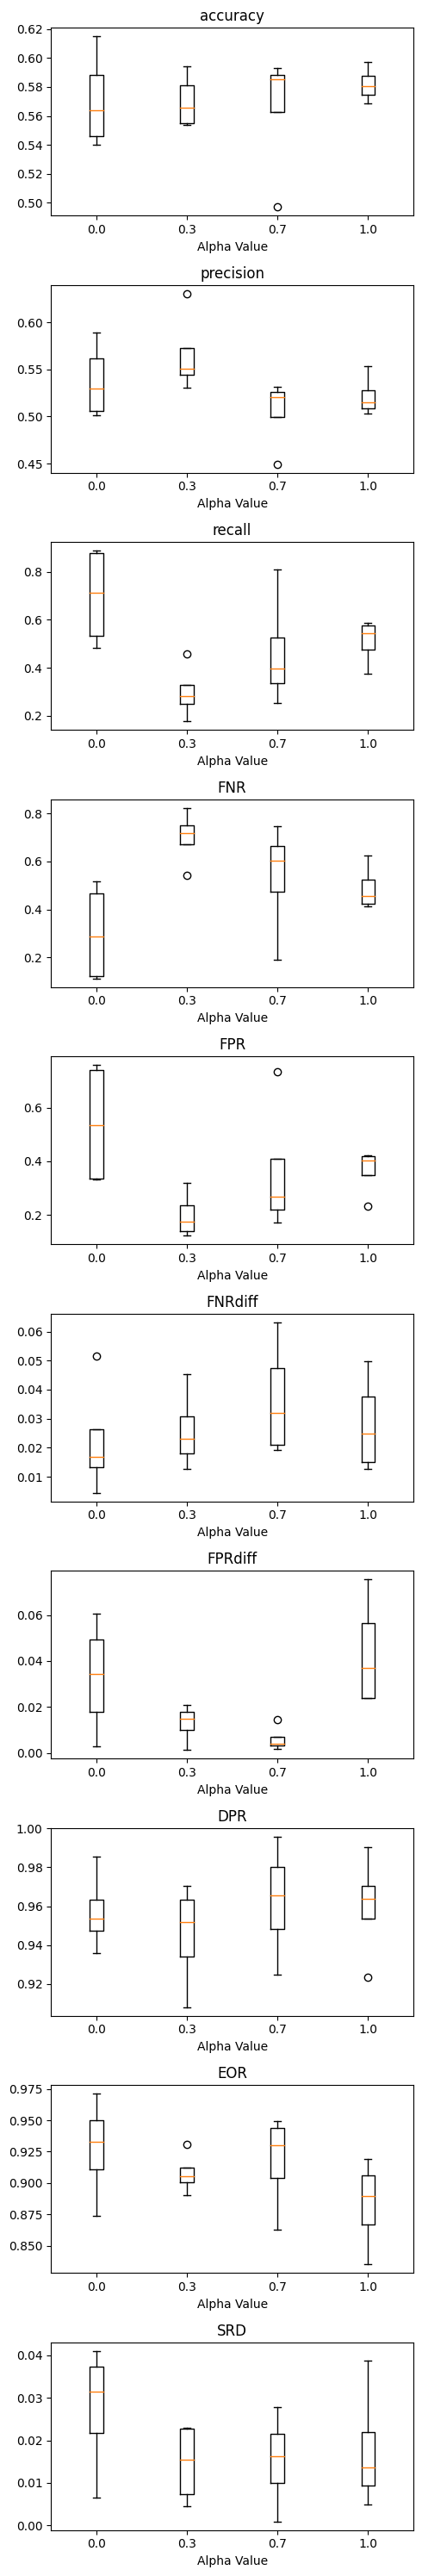

In [28]:
#@markdown ### Plot all our metrics as line plots while varying alpha

fig, axs = plt.subplots(len(results), 1, figsize=(5, 3 * len(results)))

for i in range(len(results)):
#   creating plot
  bp = axs[i].boxplot(list(results.values())[i][0], positions=[1], labels=['0.0'])
  bp2 = axs[i].boxplot(list(results.values())[i][1], positions=[2], labels=['0.3'])
  bp3 = axs[i].boxplot(list(results.values())[i][2], positions=[3], labels=['0.7'])
  bp4 = axs[i].boxplot(list(results.values())[i][3], positions=[4], labels=['1.0'])
  axs[i].set_title(list(untuned_results)[i])
  axs[i].set_xlabel("Alpha Value")
# show plot
plt.tight_layout()
plt.show()


# Problem 2, Part (d)
### **Threshold Optimizer Post-processing intervention**



In [44]:
#markdown Fit the ThresholdOptimizer model here

untuned_results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []}
post_processed_results = {
    'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
    'FNRdiff': [], 'FPRdiff': [], 'DPR': [], 'EOR': [], 'SRD': []}

for i in range(10):
  X_train, X_temp, y_train, y_temp = train_test_split(x_numeric, y_raw, test_size=0.3, random_state=i)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=i)
  sensitive_features_train = X_train['gender_Male'].replace({0:'female', 1:'male'})
  sensitive_features_test = X_test['gender_Male'].replace({0:'female', 1:'male'})
  clf = RandomForestClassifier(random_state=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  eval = MetricFrame(metrics=eval_metrics,
                     y_true=y_test,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features_test)
  fair = MetricFrame(metrics=fair_metrics,
                      y_true=y_test,
                      y_pred=y_pred,
                      sensitive_features=sensitive_features_test,
                      sample_params=params)
  for metric in untuned_results.keys():
    if metric in eval.overall:
      untuned_results[metric].append(eval.overall[metric])
    else:
      untuned_results[metric].append(fair.overall[metric])
  threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints='demographic_parity',
    objective='accuracy_score',
    prefit=True,
    predict_method='predict_proba')
  threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_features_train)
  pp_y_pred = threshold_optimizer.predict(X_test, sensitive_features=sensitive_features_test)
  pp_eval = MetricFrame(metrics=eval_metrics,
                     y_true=y_test,
                     y_pred=pp_y_pred,
                     sensitive_features=sensitive_features_test)
  pp_fair = MetricFrame(metrics=fair_metrics,
                            y_true=y_test,
                            y_pred=pp_y_pred,
                            sensitive_features=sensitive_features_test,
                            sample_params=params)
  for metric in post_processed_results.keys():
    if metric in pp_eval.overall:
      post_processed_results[metric].append(pp_eval.overall[metric])
    else:
      post_processed_results[metric].append(pp_fair.overall[metric])

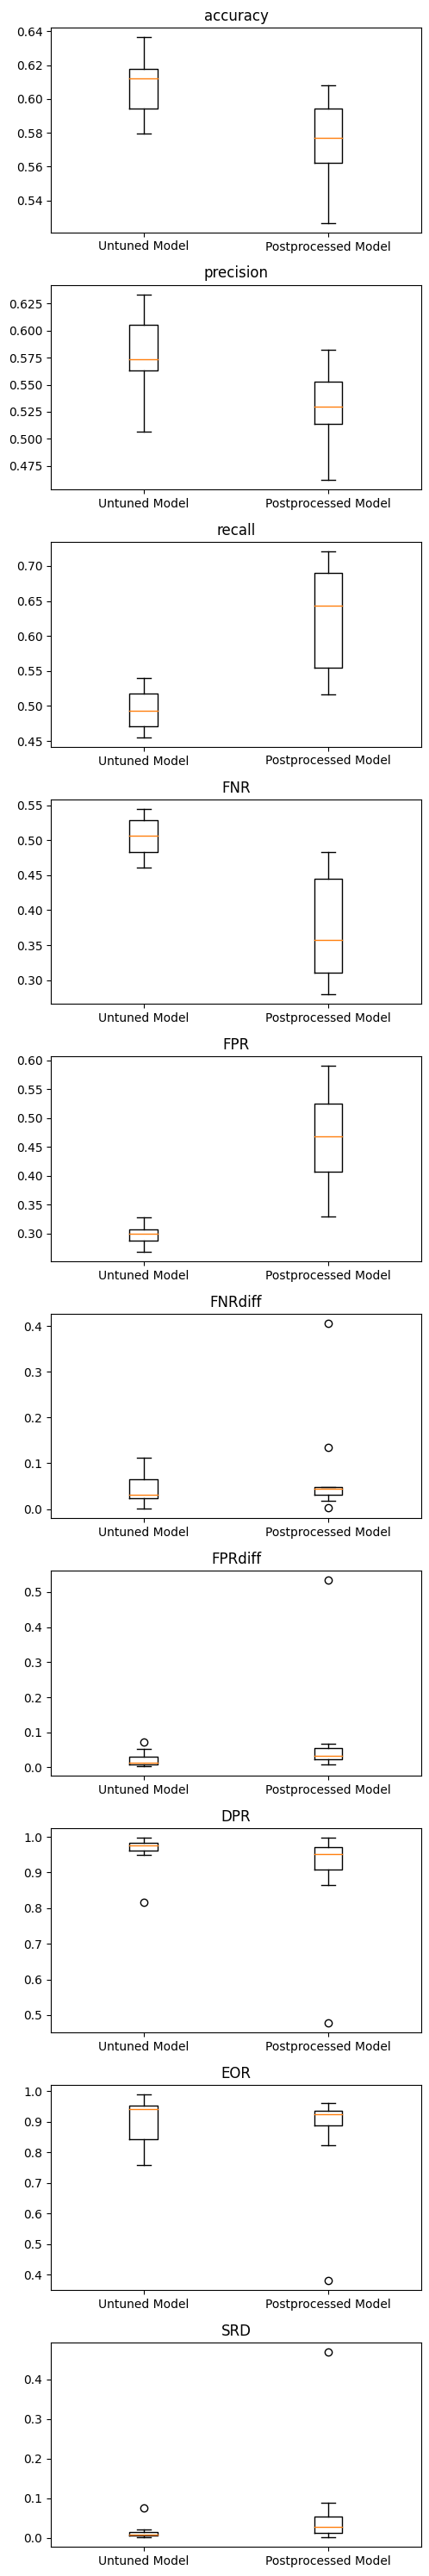

In [45]:
fig, axs = plt.subplots(len(results), 1, figsize=(5, 3 * len(results)))
# print(untuned_results)
# print(post_processed_results)
for i in range(len(results)):
  bp = axs[i].boxplot(list(untuned_results.values())[i], positions=[1], labels=['Untuned Model'])
  bp1 = axs[i].boxplot(list(post_processed_results.values())[i], positions=[2], labels=['Postprocessed Model'])
  axs[i].set_title(list(results)[i])

# show plot
plt.tight_layout()
plt.show()